## Plot results

In [1]:
# using Pkg
# Pkg.instantiate()
# Import PPSeq
import PPSeq
const seq = PPSeq

# Other Imports
import PyPlot: plt
import DelimitedFiles: readdlm
import Random
import StatsBase: quantile
import Dictionaries

# Network metadata
num_neurons = 100
max_time = 10.0

# Randomly permute neuron labels.
# (This hides the sequences, to make things interesting.)
_p = [1:num_neurons;] # Random.randperm(num_neurons)

# Load spikes.
spikes = seq.Spike[]
filename = "data/Embedded/epng_1s20i.txt"
spikeCt = 0
for (n, t) in eachrow(readdlm(filename, '\t', Float64, '\n'))
    push!(spikes, seq.Spike(_p[Int(n)], t))
    spikeCt += 1
end

numSeq = 1
numInst = 15
# i = 1
# while i <= length(filename)
#     if isdigit(filename[i])
#         j = i
#         while isdigit(filename[j])
#             j += 1
#         end
#         if numSeq == 0
#             numSeq = parse(Int64, filename[i:j - 1])
#         else
#             numInst = parse(Int64, filename[i:j - 1]) 
#         end  
#         i = j
#     end
#     i += 1
# end

##################### Must tweak config according to data ##########################################
config = Dict(
    # Model hyperparameters
    :num_sequence_types =>  numSeq,  # Types of sequences in data. Overestimating is better
    :seq_type_conc_param => 1.0,  # Assumes every sequence is equally likely (fair assumption)
    :seq_event_rate => (numSeq * numInst) / max_time,  # No. of sequences/sec.

    :mean_event_amplitude => 10.0,  # Avg. number of spikes per sequence (10 for our purposes)
    :var_event_amplitude => 5.0,  # Variance of the avg. number of spikes per sequences.
    
    :neuron_response_conc_param => 0.1,  # Idk, I thought a spike's a spike
    :neuron_offset_pseudo_obs => 0.01,  # Average delay between neurons in sequence (10 ms)
    :neuron_width_pseudo_obs => 1.0, # Causes it to train for much longer if increased
    :neuron_width_prior => 0.0001,  #  Tolerance (in sec.) for noisy delays in a sequence
    
    :num_warp_values => 1,
    :max_warp => 1.0,
    :warp_variance => 1.0,

    :mean_bkgd_spike_rate => (spikeCt - 10 * numSeq * numInst) / max_time,  # No. of non-sequence spikes / sec.
    :var_bkgd_spike_rate => 20.0,  # Variance is tight if we know the sequences
    :bkgd_spikes_conc_param => 0.5,  # Longer training if decreased
    :max_sequence_length => 15.0,  # Self-explanatory. All sequences right now are 10 spikes
    
    # MCMC Sampling parameters.
    :num_anneals => 10,
    :samples_per_anneal => 100,
    :max_temperature => 40.0,
    :save_every_during_anneal => 10,
    :samples_after_anneal => 2000,
    :save_every_after_anneal => 10,
    :split_merge_moves_during_anneal => 15,  # Increasing generally helps reduce mislabeled dupe sequences
    :split_merge_moves_after_anneal => 15,  # Same as above
    :split_merge_window => 1.0,

);

# Initialize all spikes to background process.
init_assignments = fill(-1, length(spikes))

# Construct model struct (PPSeq instance).
model = seq.construct_model(config, max_time, num_neurons)

# Run Gibbs sampling with an initial annealing period.
results = seq.easy_sample!(model, spikes, init_assignments, config);

┌ Info: Precompiling PPSeq [bde08ef1-7bcc-48ee-8e40-33ae55139814]
└ @ Base loading.jl:1423


(warp_values, warp_log_proportions) = ([1.0], [0.0])
TEMP:  39.99999999999999
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  26.549315324802276
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  17.621653605394528
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  11.696070952851464
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  7.763066894712855
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  5.152602771881631
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  3.419951893353394
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  2.269934530307346
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.5066301902946675
10-20-30-40-50-60-70-80-90-100-Done
TEMP:  1.0
10-20-30-40-50-60-70-80-90-100-Done
10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-

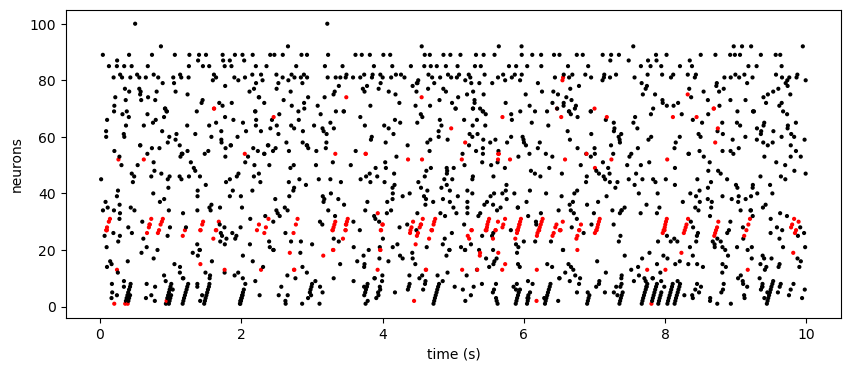

In [2]:
# Grab the final MCMC sample
final_globals = results[:globals_hist][end]
final_events = results[:latent_event_hist][end]
final_assignments = results[:assignment_hist][:, end]
# Helpful utility function that sorts the neurons to reveal sequences.
neuron_ordering = [1:num_neurons;] 
# seq.sortperm_neurons(final_globals)

# Plot model-annotated raster.
fig = seq.plot_raster(
    spikes,
    final_events,
    final_assignments,
    neuron_ordering;
    color_cycle=["red", "blue", "yellow", "green", "orange", "purple", "pink", "cyan", "magenta", "gray"] # colors for each sequence type can be modified.
)
fig.set_size_inches([10, 4]);
# fig.savefig("graphs/" * string(numSeq) * "s" * string(numInst) * "i_v2.png")

In [3]:
#=
TODO: Big Boy Algorithm
Assumptions: Background spikes are unlikely to belong to existing clusters because PP-Seq seldom produces a false negative (labels a spike as background
when it's part of a sequence). If a neuron has a high average probability of being in a new cluster, there's likely to be other neurons with similar
high probabilities that spike around the same time as it. Sequences that have less overlap with existing ones in terms of indices are considered the most
dissimilar to them.
=#

# Create two arrays with size N
# Loop through log_prob of all background spikes (in gibbs.jl?)
    # Record running total for final log_prob[k + 1] (new cluster probability) for each neuron in one array while recording running spike count on the second
    # [Check!] Ability to access index associated with spike, probably a fancy way to calculate average using one data structure...

# Use the two arrays to record average log_prob[k + 1] for each neuron
# Sort the array of averages (now stored in a dict or PQueue to remember the indices)

# Eliminate indices that are common to many clusters
# For each of the 20% (tweak) most likely candidates to be a new cluster, loop through the spikes and within a 5 ms (tweak) window before and after, record
# the indices of background spikes.
# Sort the background spikes by a formula factoring in new cluster probability and time similarity (how often they've spiked near the candidate)
# Add the highest-scoring indices as a group in a Hashmap(?) and skip them in future iterations

#### Plot raster plot with labeled sequences

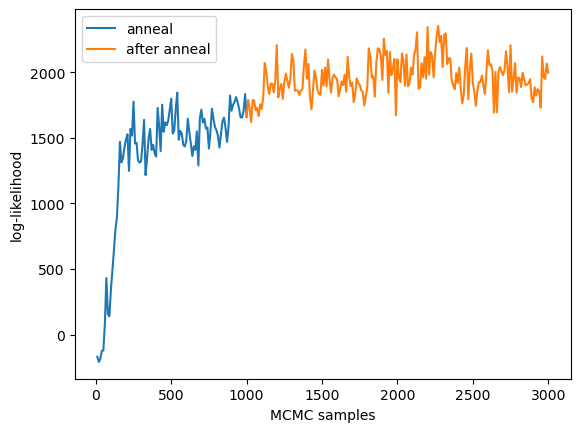

In [4]:
# Log likelihood over MCMC samples
seq.plot_log_likes(config, results);

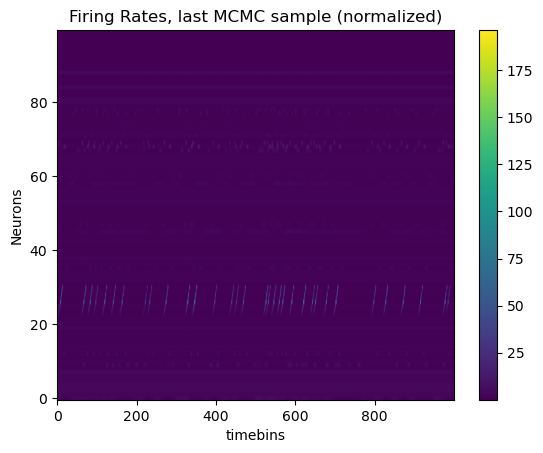

In [5]:
# Create discrete time grid.
num_timebins = 1000
dt = max_time / num_timebins
timebins = collect((0.5 * dt):dt:max_time)

# Compute a matrix firing rates (num_neurons x num_timebins)
F_nrm = seq.firing_rates(
    final_globals,
    final_events,
    timebins
)

# Plot firing rates as a heatmap
plt.title("Firing Rates, last MCMC sample (normalized)")
plt.ylabel("Neurons")
plt.xlabel("timebins")
plt.imshow(F_nrm[neuron_ordering, :]; aspect="auto", origin="lower")
plt.colorbar();